<a href="https://colab.research.google.com/github/yejxjj/AI_lab/blob/main/Speech_Recognition(%EA%B3%BC%EC%A0%9C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.8.0+cu126
2.8.0+cu126
cpu


In [2]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

/tmp/ipython-input-499805210.py:5: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
100%|██████████| 106k/106k [00:00<00:00, 2.38MB/s]


사전 학습된 모델을 불러옴

In [3]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


16000hz로 된 음성 데이터만 듣고 훈련되었음 그래서 내가 가진 음성파일도 반드시 16000hz로 변환해서 넣어줘야함

labels는 모델이 예측하고 출력할 수 있는 글자의 전체 목록이다. <br>1. 알파벳 <br>2. 특수문자 '|'단어사이의 띄어쓰기를 의미 후처리과정에서 공백으로 바꿔줌, '-': 중복 글자 처리(같은 글자가 반복되면 하나로 합쳐짐 그래서 따로 표시)

In [4]:
model = bundle.get_model().to(device)

print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


100%|██████████| 360M/360M [03:05<00:00, 2.04MB/s]


<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [11]:
file_path = "/content/drive/MyDrive/practice data2.m4a"

try:
    # torchaudio.load() 함수로 파일을 불러옵니다.
    waveform, sample_rate = torchaudio.load(file_path)

    # 5. 웨이브폼 텐서를 설정된 장치로 이동
    waveform = waveform.to(device)

    # 6. 샘플 레이트 확인 및 리샘플링
    print(f"원본 샘플 레이트: {sample_rate}")
    if sample_rate != bundle.sample_rate:
        print(f"모델이 요구하는 샘플 레이트({bundle.sample_rate})와 다르므로 리샘플링을 수행합니다.")
        waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

    print("전처리 완료!")
    print("최종 Waveform shape:", waveform.shape)

except FileNotFoundError:
    print(f"파일을 찾을 수 없습니다. 경로를 다시 확인해주세요: {file_path}")
except Exception as e:
    print(f"파일을 불러오는 중 오류가 발생했습니다: {e}")
    print("오류 메시지에 'sox_io' 또는 'soundfile' 관련 내용이 있다면, 위쪽의 !pip install soundfile 코드의 주석을 해제하고 실행한 후 다시 시도해 보세요.")


원본 샘플 레이트: 48000
모델이 요구하는 샘플 레이트(16000)와 다르므로 리샘플링을 수행합니다.
전처리 완료!
최종 Waveform shape: torch.Size([1, 168619])


In [12]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

**얇은 레이어1-4: 가장 기본적인 소리의 특징을 잡아낸다.**
<br><br> 예시: "이 소리가 'ㅅ'처럼 쉭하는 마찰음인가?", "'ㅏ'처럼 울리는 모음인가?", "소리의 높낮이가 어떤가?" 와 같은 원초적인 음향 특성(Acoustic Feature)을 파악합니다. 아직 글자나 단어의 개념은 모른다. <br> <br>
**중간 레이어5-8: 얇은 층에서 파악한 기본 소리를 조합해 더 의미 있는 단위로 만든다.**<br>
 <br> 예시: 'ㅅ', 'ㅏ', 'ㄱ', 'ㅗ', 'ㅏ' 같은 기본 소리 조각들이 합쳐져 '사'와 '과' 같은 하나의 **음절(Syllable)**을 형성하는 패턴을 학습합니다. 이제 소리 덩어리가 의미를 가지기 시작합니다. <br><br>
 **깊은 레이어 9-12: 음절,단어들이 모여 완전한 의미를 갖추도록 최종적으로 조립하고, 전체 문맥 파악**<br>
  <br>예시: '사'와 '과'가 합쳐져 '사과'라는 **단어(Word)**가 되고, 이 단어가 "어제 먹은 사과는 정말 맛있었다"라는 문장 안에서 어떤 의미로 쓰였는지 **주변 단어들과의 관계(Context)**를 최종적으로 이해합니다.

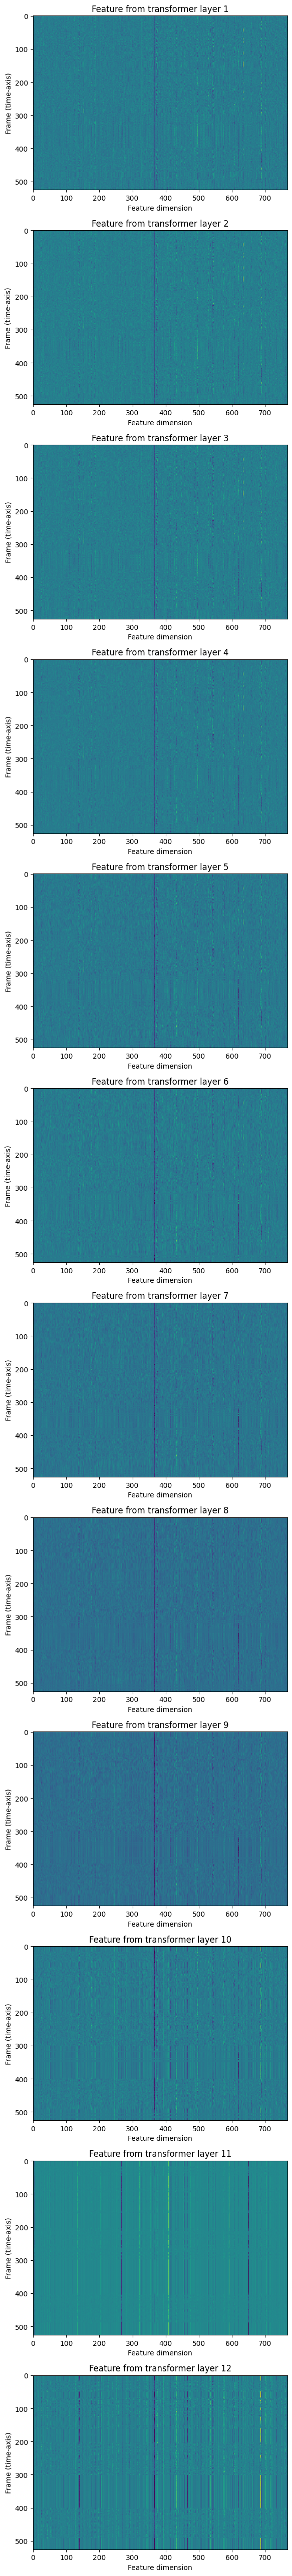

In [13]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

### 특징분류

In [15]:
with torch.inference_mode():
    emission, _ = model(waveform)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


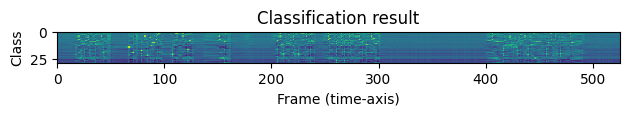

In [16]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

# 전사본 생성
<br>
레이블 확률 시퀀스로부터 전사본 생성, 가설을 생성하는 과정 = 디코딩
<br><br>
이 튜토리얼에서는 단순화를 위해 이러한 외부 구성 요소에 의존하지 않는 탐욕적 디코딩을 수행하고, 각 시간 단계에서 최적의 가설을 선택합니다. 따라서 맥락 정보는 사용되지 않으며, 단 하나의 전사본만 생성됩니다.

탐욕적 디코딩 알고리즘을 정의하는 것부터 시작해 보겠습니다.

탐욕적 디코더: 모델이 내놓은 복잡한 확률 값을 최종 텍스트로 변환할 때, '매 순간 가장 좋아 보이는 선택지만을 골라' 결과를 만드는 가장 간단하고 빠른 방식
<br><br> 장점: 매우빠름, 구현간단<br> 단점: 최적의 결과 보장하지 않음

In [17]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [18]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

전사본은 음성파일에 있는 말을 글자로 받아 적은 내용

In [20]:
print(transcript)
IPython.display.Audio(file_path)

I|TI|TAY|MY|FAVOURITE|BEECH|IS|HELPDIBEAT|IN|JETA|ISLAND|IS|WOPTABLE|SPREEPER|
